*Week 1 Velocity distributions:*

Background:
Irrespective of the start conditions, velocity distributions in multi-particle systems with
collisions between particles converge to a Maxwell-Boltzmann distribution. We will
investigate this effect by creating our own simulation of a multi-particle systems of
hard spheres in a 2D-box.

**Task I - Implementation**
In this first section will outline how we created an algorythm for simulating hard spheres in a box that includes 
* elastic collisions of hard spheres
* multi particle systems
* periodic boundary conditions for the box

All the code will be provided in easy to use functions that will be called for Task II.



Importing all external libraries used in this code

In [1]:
import matplotlib.pyplot as plt
from matplotlib import animation, rc
from IPython.display import HTML

import copy
import numpy as np
import scipy as scy

Creating a particle class:

In [2]:
class Particle:
    def __init__(self, r, x, y, vx, vy):
        self.r = r
        self.x = x
        self.y = y
        self.vx = vx
        self.vy = vy
        
    def __repr__(self):
        return str("This is a particle at %0.2f, %0.2f with v=%0.2f,%0.2f" % (self.x,self.y,self.vx,self.vy))

Defining the parameters used in the simulation later on


In [3]:
# defining the box
box_size_x = 20
box_size_y = 20

box = [box_size_x,box_size_y]

In [4]:
# defining the number of particles and their corresponding radius
number_of_particles = 50
radius = 0.5

In [5]:
# Initialising the velocities
baseline_velocity = 0.5 # same velocity magnitude for all particles 

# random direction of the velocity in 2D for each particle
vel = np.ones(number_of_particles) * baseline_velocity
angles = np.random.uniform(0,2 * np.pi, number_of_particles)

In [6]:
# Initialising the positions
# random positions for each particle
x_rand = np.random.randint(1,box[0]-1,number_of_particles)
y_rand = np.random.randint(1,box[1]-1,number_of_particles)


In [7]:
# Setting up the particle:
# Each particle gets assigned a position (x,y) and a velocity (v_x, v_y).
particles = []
for i in range(number_of_particles):
    particles.append(Particle(radius,x_rand[i],y_rand[i],np.sin(angles[i]) * vel[i],np.cos(angles[i]) * vel[i]))

In [8]:
# Defining number of simulation steps
steps = 1000

Initialise trajectory:

In [9]:
data_traj = np.zeros((number_of_particles,4,steps))
data_traj.shape

(50, 4, 1000)

Euler integrator scheme:
Define time integrator for numerical, stepwise solution of equation of motion with a discrete time step $dt$:

In [10]:
def move(p,dt):
    p.x = p.x + p.vx * dt
    p.y = p.y + p.vy * dt
    return p

Define a move function to move particles for each time step.

In [11]:
def move_unbound(p,dt):
    p.x = np.mod(p.x + p.vx * dt, box_size_x)
    p.y = np.mod(p.y + p.vy * dt, box_size_y)
    return p

Define box reflection:

In [12]:
def reflect(p):
    if (p.x + p.r) >= box[0]:
        p.vx = p.vx * (-1)
    if (p.x) <= p.r:
        p.vx = p.vx * (-1)
    if (p.y + p.r) >= box[1]:
        p.vy = p.vy * (-1)
    if (p.y) <= p.r:
        p.vy = p.vy * (-1)
    return p

Define a function that calculates new velocities for two particles (with the same mass) colliding with two different velocities in 2D. The formulas can be found here: 
 https://hermann-baum.de/elastischer_stoss/, 24.10.2024.


In [13]:
def collide_simple(particles):
    for i in range(len(particles)): # looping through all particles
        for j in range(len(particles)):
            if i < j:
                distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                if distance<(particles[i].r+particles[j].r):
                    # calculate angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))
                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi)+(particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi)+(particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    #print(particles[i],particles[j],'collided with a distance of ', distance)


Define a function to take into account particles colliding due to the periodic boundary conditions. This will be done as follows: Firstly particles will be moved by a time step $dt$. Secondly it will be checked if the particles have collided. If so their positions will be reset to where the particles just touch one another. At this point the collision function will calculate new velocities and their corresponding directions for the particles in the subsequent time step. To take into account the periodic boundary conditions the particles in the left border region of the box will be moved to the right side outside of the box. Again collisions will be detected for these particles and new velocities calculated. Finally the periodic boun dary condition will be applied.

In [14]:
# check if particles are in border area
# if a particle is in the left border area (smaller than one radius distance) it will be moved to the right outside of the box. Same for the bottom of the box.
def border_control(particles, radius, box_size_x, box_size_y):
    # for i in range(len(particles)):
    #     for j in range(len(particles)):
            if  particles.x < (box_size_x - radius):
                particles.x = particles.x + box_size_x
            if  particles.y < (box_size_y - radius):
                particles.y = particles.y + box_size_y
  
particles[0].x = 9.6
particles[0].y = 5
particles[0].vx = 0.4
particles[0].vy = 0  

b = border_control(particles[0], 0.5, 10, 10)            

print(particles[0])

This is a particle at 9.60, 15.00 with v=0.40,0.00


In [15]:
# https://hermann-baum.de/elastischer_stoss/
def calculate_distance(particle_1, particle_2):
    distance = np.sqrt(np.abs(particle_1.x - particle_2.x)**2+np.abs(particle_1.y - particle_2.y)**2)
    return distance


def collide_boundary(particles,step):
    for i in range(len(particles)):
        for j in range(len(particles)):
            if i < j:
                distance = calculate_distance(particles[i],particles[j])
                #print(i,j)
                
                #distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                
                if distance < (particles[i].r + particles[j].r):
                    print(step)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    # angle between x-axis and line between particles
                    phi = np.arctan((particles[j].y - particles[i].y)/(particles[j].x - particles[i].x))

                    # move the particles out
                    distance_x = np.sign(particles[j].x-particles[i].x) * ((particles[i].r+particles[j].r)-distance) * np.cos(phi)
                    distance_y = np.sign(particles[j].y-particles[i].y) * ((particles[i].r+particles[j].r)-distance) * np.sin(phi)
                    print((particles[i].r+particles[j].r)-distance,phi,np.cos(phi),np.sin(phi))
                    print(distance_x,distance_y)
                    particles[i].x  = particles[i].x - (distance_x/2)
                    particles[i].y  = particles[i].y - (distance_y/2)
                    particles[j].x  = particles[j].x + (distance_x/2)
                    particles[j].y  = particles[j].y + (distance_y/2)

                    # change the velocities
                    particles[i].vx = ( particles[i].vx*np.sin(phi)-particles[i].vy*np.cos(phi))*np.sin(phi) + (particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.cos(phi)
                    particles[i].vy = (-particles[i].vx*np.sin(phi)+particles[i].vy*np.cos(phi))*np.cos(phi) + (particles[j].vx*np.cos(phi)+particles[j].vy*np.sin(phi))*np.sin(phi)
                    particles[j].vx = ( particles[j].vx*np.sin(phi)-particles[j].vy*np.cos(phi))*np.sin(phi) + (particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.cos(phi)
                    particles[j].vy = (-particles[j].vx*np.sin(phi)+particles[j].vy*np.cos(phi))*np.cos(phi) + (particles[i].vx*np.cos(phi)+particles[i].vy*np.sin(phi))*np.sin(phi)
                    distance = np.sqrt(np.abs(particles[i].x-particles[j].x)**2+np.abs(particles[i].y-particles[j].y)**2)
                    print(particles[i],particles[j],'collided with a distance of ', distance)
                    

In [16]:
# particles[0].x = 5
# particles[0].y = 10
# particles[0].vx = 0.4
# particles[0].vy = 0
# 
# particles[1].x = 15
# particles[1].y = 10
# particles[1].vx = -0.4
# particles[1].vy = 0
# 
# particles[2].x = 10
# particles[2].y = 14.5
# particles[2].vx = 0
# particles[2].vy = -0.4
# 
# print(particles)

**Task II - Carrying out the simulation**
In the following the above functions will be implemented to run a simulation

In [17]:

for i in range(steps):
    for j in range(number_of_particles):
        #move(p1,1)
        #reflect(p1)
        move_unbound(particles[j],1)
    collide_boundary(particles,i)
    for j in range(number_of_particles):
        data_traj[j,:,i] = [particles[j].x, particles[j].y, particles[j].vx, particles[j].vy]
        

0
This is a particle at 14.90, 7.49 with v=-0.10,0.49 This is a particle at 15.73, 7.58 with v=-0.27,-0.42 collided with a distance of  0.8381264930484816
0.16187350695151836 0.10714081402512779 0.9942659113419721 0.10693595065887715
0.16094530991127246 0.017310097352346974
This is a particle at 14.82, 7.48 with v=-0.36,0.49 This is a particle at 15.81, 7.59 with v=-0.27,-0.42 collided with a distance of  1.0000000000000009
0
This is a particle at 14.82, 7.48 with v=-0.36,0.49 This is a particle at 14.90, 7.49 with v=-0.10,0.49 collided with a distance of  0.08066185756573499
0.919338142434265 0.10679722653174567 0.9943025945087676 0.10659432702134441
0.9141003002532606 0.09799623059783336
This is a particle at 14.36, 7.43 with v=-0.11,0.49 This is a particle at 15.35, 7.54 with v=-0.11,0.49 collided with a distance of  0.9999999999999992
0
This is a particle at 5.58, 4.73 with v=-0.42,-0.27 This is a particle at 5.12, 4.51 with v=0.12,-0.49 collided with a distance of  0.5117788465014

In [18]:
#data_traj

* Plotting trajectory with Matplotlib:

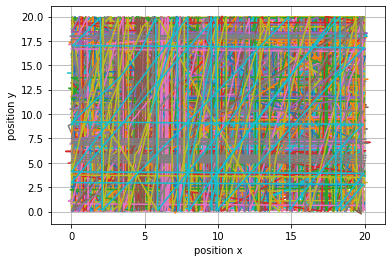

In [19]:
for data_traj_j in data_traj:
    plt.plot(data_traj_j[0],data_traj_j[1],'-')
plt.xlabel('position x')
plt.ylabel('position y')

plt.grid()
plt.show()

**Animate trajectory:**

* Set up the figure, the axis, and the plot element we want to animate

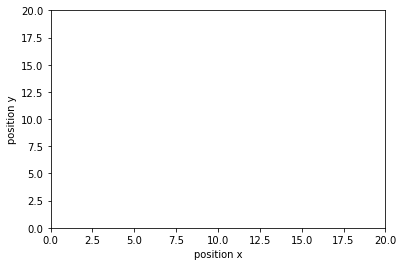

In [20]:
fig, ax = plt.subplots()

ax.set_xlim((0, box[0]))
ax.set_ylim((0, box[1]))

plt.xlabel('position x')
plt.ylabel('position y')

# make the points in the plot the correct size according to the radius of the particles
# use ax.transData.transform to convert radius size from particle to markerSize from pyplot
desired_size_in_data_units = radius
data_to_points = ax.transData.transform((desired_size_in_data_units, 0)) - ax.transData.transform((0, 0))
marker_size_in_points = data_to_points[0]


dot, = ax.plot([], [], 'bo', ms=marker_size_in_points)


#ax.plot(5,5, 'bo', ms=marker_size_in_points)
# dont show the plot 
#plt.close()

In [21]:
# * initialization function: plot the background of each frame
def init():
    dot.set_data([], [])
    return (dot,)

In [33]:
data_traj[:,0,1]
# data_traj [simulation_iterations, (x, y, v_x, v_y), particle]

array([[10.        , 10.4       , 10.8       , ...,  5.07455771,
         5.02365369,  4.97274967],
       [12.36627464, 12.73254928, 13.09882393, ...,  0.37891749,
         0.32893545,  0.2789534 ],
       [12.59510667, 12.19021334, 11.78532001, ...,  4.37371822,
         4.33068281,  4.28764741],
       ...,
       [11.65291597, 11.45673937, 11.16109296, ..., 16.43250645,
        16.38365179, 16.33479714],
       [ 5.92082225,  5.87384286,  5.80312835, ...,  0.81693076,
         0.7775963 ,  0.73826185],
       [12.71212468, 12.50165541, 12.40839496, ...,  5.49819099,
         5.46508322,  5.43197546]])

In [23]:
# animation function. This is called sequentially
def animate(i):
    x = data_traj[:,0,i]
    y = data_traj[:,1,i]
    dot.set_data(x, y)
    return (dot,)


* call the animator. blit=True means only re-draw the parts that have changed.

In [24]:
anim = animation.FuncAnimation(fig, animate, init_func=init,
                               frames=steps, interval=60, blit=True)

In [25]:
HTML(anim.to_html5_video())
anim.save('animation.mp4', writer='ffmpeg', fps=30)


***Task III - analysis of the velocity distributions:***

Finally the results from the above simulation can be analysed.

Analysis of the velocity distribution in x direction

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
1
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
2
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
3
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
4
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
5
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
6
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
7
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
8
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9
9


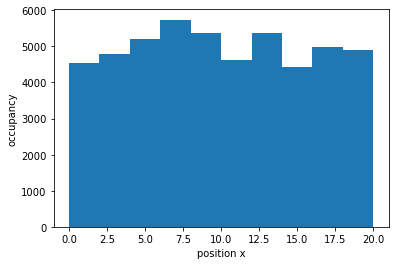

In [41]:
#plt.hist(data_traj[0],range=(0,box[0]),bins=10)

# histogram of the x positions

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 0, i])
    
plt.hist(a,range=(0,box[0]),bins=10)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

Analysis of the velocity distribution in the y direction

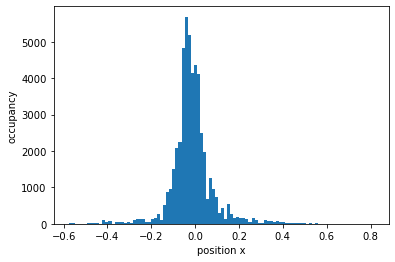

In [45]:
# plt.hist(data_traj[1],range=(0,box[1]),bins=3)
# plt.xlabel('position y')
# plt.ylabel('occupancy')
# plt.show()

# histogram of the x velocity

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 2, i])
    
plt.hist(a,bins=100)
plt.xlabel('position x')
plt.ylabel('occupancy')
plt.show()

Analysis of the velocity distribution in the xy Plane

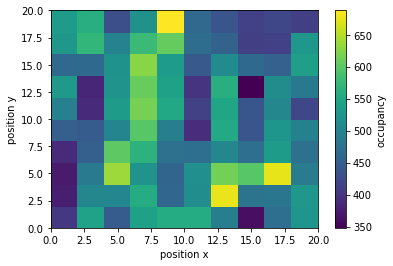

In [52]:
# 2d plot of the position distribution

a = []
for i in range(steps):
    for j in range(number_of_particles):
        a.append((data_traj)[j, 0, i])
b = []
for i in range(steps):
    for j in range(number_of_particles):
        b.append((data_traj)[j, 1, i])
    

plt.hist2d(a, b, range=[[0,box[0]],[0,box[1]]], bins=10)
plt.xlabel('position x')
plt.ylabel('position y')
plt.colorbar().set_label('occupancy')
plt.show()

**Interpretation:**
* in the reduced data projection, the occupancy of each bin seems even and well-distributed
* in the full dimensional projection, it can be seen easily that the box is **not** fully sampled, large undersampled patches present
* *data dimensionality reduction always brings the danger of wrong projection!*

**Solution for improvements:**
* enhance sampling by
    * prolong the simulation
    * increase the time step
* *Caveat: all solutions come with problems like increased computational cost or sampling errors!*